In [1]:
# imports and utils

import tensorflow.compat.v2 as tf
import ddsp.training
_AUTOTUNE = tf.data.experimental.AUTOTUNE
from IPython.display import Audio, display
from livelossplot import PlotLosses
import numpy as np
import random 
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import time
import data

# define constants
CLIP_S=4
N_SAMPLES=16000*CLIP_S
SAMPLE_RATE=16000
SEED=1
FT_FRAME_RATE=250

tf.random.set_seed(
    SEED
)
np.random.seed(SEED)
random.seed(SEED)


# define some utilis
def play(audio):
  display(Audio(audio,rate=SAMPLE_RATE))


In [2]:
USE_NSYNTH=False

if USE_NSYNTH:
   
    tfds.load("nsynth/gansynth_subset.f0_and_loudness",split="train", try_gcs=False,download=True) 
    trn_data_provider = data.CustomNSynthTfds(data_dir="/root/tensorflow_datasets/",split="train")

    tfds.load("nsynth/gansynth_subset.f0_and_loudness",split="valid", try_gcs=False,download=True) 
    val_data_provider = data.CustomNSynthTfds(data_dir="/root/tensorflow_datasets/",split="valid")

    def crepe_is_certain(x):
        is_playing = tf.cast(x["loudness_db"]>-100.0,dtype=tf.float32)
        average_certainty=tf.reduce_sum(x["f0_confidence"]*is_playing)/tf.reduce_sum(is_playing)
        return average_certainty

    INSTRUMENT_FAMILY=2

    def preprocess_dataset(dataset):
        if INSTRUMENT_FAMILY!="all":
            dataset=dataset.filter(lambda x: x["instrument_family"]==INSTRUMENT_FAMILY)
        return dataset


    trn_dataset = preprocess_dataset(trn_data_provider.get_dataset())
    val_dataset = preprocess_dataset(val_data_provider.get_dataset())

else:
    INSTRUMENT_FAMILY="solos-saxophone-clean"
    
    trn_data_provider=data.MultiTFRecordProvider(f"datasets/{INSTRUMENT_FAMILY}/tfr/trn/*")
    val_data_provider=data.MultiTFRecordProvider(f"datasets/{INSTRUMENT_FAMILY}/tfr/val/*")
    
    trn_dataset= trn_data_provider.get_dataset()
    val_dataset=val_data_provider.get_dataset(shuffle=False)
    
    print(f"{len(list(trn_dataset))} examples pre filtering")
    
    trn_dataset=trn_dataset.filter(lambda x: tf.math.count_nonzero(x["audio"])>0)
    val_dataset=val_dataset.filter(lambda x: tf.math.count_nonzero(x["audio"])>0)
    
    print(f"{len(list(trn_dataset))} examples post filtering")

3587 examples pre filtering
3395 examples post filtering


In [3]:
class CustomRnnFcDecoder(ddsp.training.nn.OutputSplitsLayer):
  """RNN and FC stacks for f0 and loudness.
  Allows for bidirectionality
  """

  def __init__(self,
               rnn_channels=512,
               rnn_type='gru',
               ch=512,
               layers_per_stack=3,
               input_keys=('ld_scaled', 'f0_scaled','z'),
               output_splits=(('amps', 1), ('harmonic_distribution', 40)),
               bidir=True,
               **kwargs):
    super().__init__(
        input_keys=input_keys, output_splits=output_splits, **kwargs)
    stack = lambda: ddsp.training.nn.FcStack(ch, layers_per_stack)
    
    # z should be considered as input
    self.input_stacks = [stack() for k in self.input_keys]
    
    self.rnn = ddsp.training.nn.Rnn(rnn_channels, rnn_type,bidir=bidir)
    self.out_stack = stack()

  def compute_output(self, *inputs):
    # Initial processing.
        
    inputs = [stack(x) for stack, x in zip(self.input_stacks, inputs)]

    # Run an RNN over the latents.
    x = tf.concat(inputs, axis=-1)
    x = self.rnn(x)
    x = tf.concat(inputs + [x], axis=-1)

    # Final processing.
    return self.out_stack(x)
            
class MultiInstrumentAutoencoder(ddsp.training.models.autoencoder.Autoencoder):
    def __init__(self,
               preprocessor=None,
               encoder=None,
               decoder=None,
               processor_group=None,
               losses=None,
               n_instruments=None,
               instrument_weight_initializers={},
               **kwargs):
        super().__init__(preprocessor,encoder,decoder,processor_group,losses,**kwargs)
        
        self.n_instruments=n_instruments
        self.instrument_weight_initializers=instrument_weight_initializers
        self.initialize_instrument_weights()
    
    def initialize_instrument_weights(self):
        self.instrument_weights={}
        for weight_name,weight_initializer in self.instrument_weight_initializers.items():
            self.instrument_weights[weight_name]=tf.Variable(weight_initializer(self.n_instruments))
          
    def call(self, batch, train_shared):
        if self.encoder is not None:
            self.encoder.trainable=train_shared
        if self.decoder is not None:
            self.decoder.trainable=train_shared

        for weight_name,weights in self.instrument_weights.items():
            batch[weight_name]=tf.gather(weights,batch["instrument_idx"])
        
        # tile z so that is same size as f0_hz
        # this is quite ugly as we are treating "z" specially
        batch["z"]=tf.tanh(tf.tile(batch["z"],[1,batch["f0_hz"].shape[1],1]))
        
        return super().call(batch,training=False)

from typing import Dict, Text

class Gain(ddsp.processors.Processor):
    def __init__(self, name: Text = 'gain'):
        super().__init__(name=name)
    
    def get_signal(self, signal: tf.Tensor,
                 gain_scaled: tf.Tensor) -> tf.Tensor:
        return gain_scaled * signal
    
    def get_controls(self,signal: tf.Tensor,
                 gain: tf.Tensor) -> tf.Tensor:
        return {"signal":signal,"gain_scaled":tf.nn.relu(gain)}
    


In [10]:
## FN - REVERB MODEL

# define model

N_NOISE_MAGNITUDES=64
N_HARMONICS=64
N_INSTRUMENTS=1050

BIDIRECTIONAL=False
Z_SIZE=512

USE_FNR=True

IR_DURATION=1
IR_SIZE=int(SAMPLE_RATE*IR_DURATION)
N_FNR_MAGNITUDES=64
FNR_FRAMERATE=500

preprocessor=ddsp.training.preprocessing.F0LoudnessPreprocessor()

decoder = CustomRnnFcDecoder(
               rnn_channels=512,
               rnn_type='gru',
               ch=512,
               layers_per_stack=3,
               input_keys=("ld_scaled", 'f0_scaled','z'),
               output_splits=(('amps', 1), ('harmonic_distribution', N_HARMONICS),('magnitudes', N_NOISE_MAGNITUDES)),
               bidir=BIDIRECTIONAL
               )

harmonic_synth = ddsp.synths.Harmonic(
    n_samples=N_SAMPLES, sample_rate=SAMPLE_RATE, name='harmonic')

filtered_noise = ddsp.synths.FilteredNoise(
    n_samples=N_SAMPLES, window_size=0, initial_bias=-3.0, name='noise')

reverb = ddsp.effects.FilteredNoiseReverb(name="reverb",initial_bias=-3,reverb_length=IR_SIZE,n_frames=FNR_FRAMERATE,n_filter_banks=N_FNR_MAGNITUDES)

synth_add = ddsp.processors.Add(name='synth_add')
reverb_add = ddsp.processors.Add(name='reverb_add')

dry_gain = Gain(name='dry_gain')
wet_gain = Gain(name='wet_gain')

dag = [
  (harmonic_synth, ['amps', 'harmonic_distribution', 'f0_hz']),
  (filtered_noise, ['magnitudes']),
  (synth_add, ['harmonic/signal', 'noise/signal']),
  (reverb, ["synth_add/signal","fnr_magnitudes"]),
  (wet_gain,["reverb/signal","wet_gain"]),
  (dry_gain,["synth_add/signal","dry_gain"]),
  (reverb_add,["wet_gain/signal","dry_gain/signal"])
]

processor_group=ddsp.processors.ProcessorGroup(dag=dag)

spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                              mag_weight=1.0,
                                              logmag_weight=1.0)

instrument_weight_initializers = {
    "z": lambda batch_size: tf.random.normal([batch_size,1,Z_SIZE]),
    "fnr_magnitudes": lambda batch_size: tf.random.normal([batch_size,IR_DURATION*FNR_FRAMERATE,N_FNR_MAGNITUDES]),
    "dry_gain":lambda batch_size : tf.ones([batch_size,1]),
    "wet_gain":lambda batch_size : tf.ones([batch_size,1])
}

ae = MultiInstrumentAutoencoder(
    preprocessor=preprocessor,
    decoder=decoder,
    processor_group=processor_group,
    n_instruments=N_INSTRUMENTS,
    instrument_weight_initializers=instrument_weight_initializers
)

In [11]:
plotlosses = PlotLosses()

In [12]:
checkpoint_path=f"artefacts/model_{'bidir' if BIDIRECTIONAL else 'unidir'}_z{Z_SIZE}{'_fn' if USE_FNR else ''}_conv_family_{INSTRUMENT_FAMILY}"
try:
    print("loading checkpoint")
    ae.load_weights(checkpoint_path)
except:
    print("couldn't load checkpoint")
    pass

loading checkpoint
couldn't load checkpoint


batch nr 0, loss: 34.53160858154297


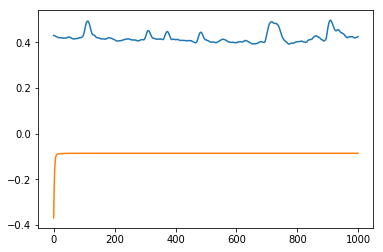

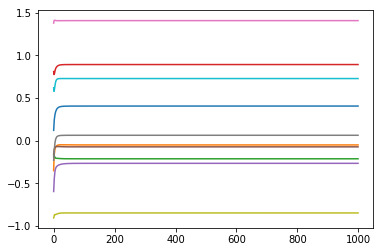

batch nr 10, loss: 15.032965660095215
batch nr 20, loss: 14.910895347595215
batch nr 30, loss: 14.87919807434082
batch nr 40, loss: 11.964858055114746
batch nr 50, loss: 11.208072662353516
batch nr 60, loss: 12.802188873291016
batch nr 70, loss: 14.65770149230957
batch nr 80, loss: 11.80030632019043
batch nr 90, loss: 12.894854545593262


In [ ]:
## training loop with adam

BATCH_SIZE=10
batched_trn_dataset=trn_dataset.shuffle(10000).batch(BATCH_SIZE,drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

e=0

while True:
  batch_counter=0
  epoch_loss=0   
  for batch in batched_trn_dataset:
    
    with tf.GradientTape() as tape:
    
        a = time.time()

        output=ae(batch,train_shared=True)

        loss_value=spectral_loss(batch["audio"],output["audio_synth"])

        gradients = tape.gradient(loss_value, [*ae.trainable_variables])

        epoch_loss+=loss_value.numpy()

        optimizer.apply_gradients(zip(gradients, [*ae.trainable_variables]))
        

        if batch_counter % 10==0:
            print(f"batch nr {batch_counter}, loss: {loss_value.numpy()}")
        
        if batch_counter ==0:
           
            
            #plt.plot(output["ir"][0])
            #plt.show()
            
            plt.plot(output["ld_scaled"][0,:])
            
            plt.plot(output["amps"][0,:])
            plt.show()
            
            plt.plot(output["harmonic_distribution"][0,:,:10])
            plt.show()
            
            play(tf.reshape(output["audio"],(-1)))

            play(tf.reshape(output['audio_synth'],(-1)))
            play(tf.reshape(output['synth_add']["signal"],(-1))) 
            #play(tf.reshape(output["ir"],(-1)))
            
        batch_counter+=1
  
  plotlosses.update({'loss': epoch_loss/batch_counter,})

  plotlosses.send()

  print(f"summary nr: {e}")


  play(tf.reshape(output["audio"],(-1)))
  

  play(tf.reshape(output['audio_synth'],(-1)))
  play(tf.reshape(output['synth_add']["signal"],(-1))) 
  #play(tf.reshape(output["ir"],(-1)))
    

    
  ae.save_weights(checkpoint_path)

  e+=1




In [ ]:
import pydash
import random
import copy
## validation

## make sure it's actually 16 seconds unedited fit data
## check if playback normalizes check actual loudness on output

def join_batch(batch):
    for key in batch.keys():
        assert len(batch[key].shape)<3
        if len(batch[key].shape)==2:
            batch[key]=tf.reshape(batch[key],(1,-1))
    return batch
     
def window_signal(a,window_len,hop_len):
     assert(a.shape[0]==1)
     windows=[]
     start_frame=0
     while True:
        windows.append(a[:,start_frame:start_frame+window_len,...])
        start_frame+=hop_len
        if start_frame > a.shape[1]-window_len:
            break
     return tf.concat(windows,axis=0)
            

def window_sample(instance,win_s,hop_s):
    instance["audio"]=window_signal(instance["audio"],win_s*SAMPLE_RATE,hop_s*SAMPLE_RATE)
    for key in ["f0_hz","loudness_db","f0_confidence"]:
        instance[key]=window_signal(instance[key],win_s*FT_FRAME_RATE,hop_s*FT_FRAME_RATE)
    instance["instrument"]=tf.repeat(instance["instrument"][0],(instance["audio"].shape[0]))
    for key,item in instance.items():
        assert(len(item.shape)<2 or item.shape[0]>1)
    return instance

def join_and_window(instance,win_s=4,hop_s=1):
    return window_sample(join_batch(instance),win_s,hop_s)


ae_test=ae

ae_test.clear_instruments()

print("v")

val_dataset=list(val_dataset)

VAL_LR=5e-4

# group by instrument id
val_dataset_by_instrument=pydash.collections.group_by(list(val_dataset),lambda x: str(x["instrument"].numpy()))

fit_iterations=1000

def rf2cf(row_form):
    return {k:[s[k] for s in row_form] for k in row_form[0].keys()}
    
DEMO_NOTE_SAMPLES=int(4.0*SAMPLE_RATE)

N_FIT_SECONDS=16

N_FIT_WINDOWS=int(N_FIT_SECONDS/CLIP_S)

print(N_FIT_WINDOWS)

val_dataset_by_instrument = {k:v for k,v in val_dataset_by_instrument.items() if len(v)>N_FIT_WINDOWS*2}

for instrument_set in val_dataset_by_instrument.values(): 
    
    val_optimizer = tf.keras.optimizers.Adam(learning_rate=VAL_LR)
    
    fit_data=instrument_set[:N_FIT_WINDOWS]
    
    demo_data=instrument_set[N_FIT_WINDOWS:N_FIT_WINDOWS*2]
    
    #convert to column form
    fit_data = rf2cf(fit_data)
            
    fit_batch= next(iter(tf.data.Dataset.from_tensor_slices(fit_data).batch(len(list(fit_data)))))
    
    print("#")
    fit_batch=join_and_window(fit_batch,4,1)
        
    fit_data=tf.data.Dataset.from_tensor_slices(fit_batch)
    
    print(len(list(fit_data)))
    
    fit_batched=fit_data.batch(BATCH_SIZE)
        
        
    for i in range(fit_iterations):
        
        epoch_loss=0
        
        batch_counter=0
        
        for fit_batch in fit_batched:
            with tf.GradientTape() as tape:

              output=ae_test(fit_batch,training=False)

              loss_value=custom_loss(fit_batch,output,0.0 if FN_REVERB else 0.5)
                
              epoch_loss+=loss_value.numpy()
            
              batch_counter+=1

              gradients = tape.gradient(loss_value, [ae_test.instrument_ir,ae_test.instrument_z])
             
            val_optimizer.apply_gradients(zip(gradients, [ae_test.instrument_ir,ae_test.instrument_z]))
        
        if i % 10 == 0:
             print(epoch_loss/batch_counter)
   
    print(loss_value)
           
    play(tf.reshape(fit_batch["audio"],(-1)))
    play(tf.reshape(output['audio_synth'],(-1)))
    play(tf.reshape(output['add']["signal"],(-1)))
    
    
    print("transposed down")
    transposed_fit_batch = copy.deepcopy(fit_batch)
    print(transposed_fit_batch.keys())
    transposed_fit_batch["f0_hz"]=transposed_fit_batch["f0_hz"]*0.7
    
    transposed_output=ae_test(transposed_fit_batch,training=False)
    play(tf.reshape(transposed_output['audio_synth'],(-1)))
    
    
    print("transposed up") 
    transposed_fit_batch = copy.deepcopy(fit_batch)
    print(transposed_fit_batch.keys())
    transposed_fit_batch["f0_hz"]=transposed_fit_batch["f0_hz"]*1.3
    
    transposed_output=ae_test(transposed_fit_batch,training=False)
    play(tf.reshape(transposed_output['audio_synth'],(-1)))
    
    loudnesses=[]
    
    print("very lower loudness") 
    
    transposed_fit_batch = copy.deepcopy(fit_batch)
    print(transposed_fit_batch.keys())
    transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]-12
    
    transposed_output=ae_test(transposed_fit_batch,training=False)
    play(tf.reshape(transposed_output['audio_synth'],(-1)))
    
    loudnesses.append(ddsp.spectral_ops.compute_loudness(tf.reshape(transposed_output['audio_synth'],(-1))))
    
    print("lower loudness") 
    
    transposed_fit_batch = copy.deepcopy(fit_batch)
    print(transposed_fit_batch.keys())
    transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]-6
    
    transposed_output=ae_test(transposed_fit_batch,training=False)
    play(tf.reshape(transposed_output['audio_synth'],(-1)))
    
    loudnesses.append(ddsp.spectral_ops.compute_loudness(tf.reshape(transposed_output['audio_synth'],(-1))))
    
    print("higher loudness") 
    
    transposed_fit_batch = copy.deepcopy(fit_batch)
    print(transposed_fit_batch.keys())
    transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]+6
    
    transposed_output=ae_test(transposed_fit_batch,training=False)
    play(tf.reshape(transposed_output['audio_synth'],(-1)))
    
    loudnesses.append(ddsp.spectral_ops.compute_loudness(tf.reshape(transposed_output['audio_synth'],(-1))))
    
    print("very higher loudness") 
    
    transposed_fit_batch = copy.deepcopy(fit_batch)
    print(transposed_fit_batch.keys())
    transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]+12
    
    transposed_output=ae_test(transposed_fit_batch,training=False)
    play(tf.reshape(transposed_output['audio_synth'],(-1)))
    
    loudnesses.append(ddsp.spectral_ops.compute_loudness(tf.reshape(transposed_output['audio_synth'],(-1))))
    
    for ld in loudnesses:
        plt.plot(ld)
    plt.show()
        
    N_SCALE_SAMPLES=len(demo_data)
        
    scale_data = rf2cf(demo_data) 
    scale_batch= next(iter(tf.data.Dataset.from_tensor_slices(scale_data).batch(N_SCALE_SAMPLES)))
    
    play(tf.reshape(scale_batch["audio"][:,:DEMO_NOTE_SAMPLES],(-1)))
         
    scale_batch_output = ae_test(scale_batch,training=False)
    
    play(tf.reshape(scale_batch_output['audio_synth'][:,:DEMO_NOTE_SAMPLES],(-1)))